Get best bin sizes from comparing to Travis ages, also adding columns in the end for errors

In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [12]:
df_prot_s=pd.read_pickle('minchisq.pkl')
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')

df_prot_s=df_prot_s.dropna(subset=['age','iso_age'])
df_rvar_s=df_rvar_s.dropna(subset=['age','iso_age'])


In [13]:
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,kepid_y,X,Y,z,R,parallax,kepid,v_t,Lz_est,kin_age_Sharma2020
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,757450.0,0.292384,-0.769703,0.141026,7.944988,1.168913,757450.0,33.889670,269.253033,0.888474
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,892718.0,0.303262,-0.801109,0.147161,7.937269,1.123321,892718.0,49.088081,389.625320,0.332151
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,892772.0,0.228827,-0.605497,0.111267,7.994137,1.499367,892772.0,43.437266,347.243470,0.460172
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,892832.0,0.275032,-0.727739,0.133604,7.958311,1.239068,892832.0,91.357351,727.050225,-0.038991
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,892834.0,0.197754,-0.522096,0.095666,8.019260,1.737008,892834.0,16.909004,135.597695,0.445367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88409,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,12935144.0,0.074333,-0.665727,0.203878,8.152893,1.399630,12935144.0,84.082452,685.515233,-0.054381
88410,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,12983952.0,0.130032,-1.163034,0.360703,8.153345,0.787841,12983952.0,25.186284,205.352468,0.460145
88411,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,12984012.0,0.151450,-1.360554,0.421496,8.162736,0.669294,12984012.0,77.666784,633.973444,0.037189
88412,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,12984138.0,0.097330,-0.878833,0.271680,8.150190,1.052836,12984138.0,3.918576,31.937140,1.928145


In [22]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'

### New AVR
def f_Lz(Lz):
    alpha=0.58
    lzsun=232.
    lumbda=1130.
    return (alpha*np.power(Lz/lzsun,2.)+np.exp(-(Lz-lzsun)/lumbda))/1+alpha

def f_feh(FeH):
    gamma=-0.52
    return 1.+gamma*FeH

def f_z(z):
    gamma=0.2
    return 1.+gamma*abs(z)

def f_tao(vd,Lz,FeH,z):
    sigma=21.1
    return vd/sigma/f_z(z)/f_feh(FeH)/f_Lz(Lz)

def v_to_age(vd,Lz,FeH,z):
    beta=0.441
    return np.power(f_tao(vd,Lz,FeH,z),1./beta)*10.1-0.1


def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
            #mask = mask & (paras[:,j]>=checkpara[j]-binfs[j]/2)
            #mask = mask & (paras[:,j]<=checkpara[j]+binfs[j]/2)
        
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    df['vel_dis_Sharma2020']=kin_age
    df['kin_age_Sharma2020']=v_to_age(kin_age,df['Lz_est'],np.ones(len(df))*-0.05,
                                      df['z'])
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
    df['vel_dis_Sharma2020']=kin_age

    df['kin_age_Sharma2020']=v_to_age(kin_age,df['Lz_est'],np.ones(len(df))*-0.05,
                                      df['z'])
    
import time
from tqdm import trange
# get average ages
def getkinAges_err(df,fs,binfs,sampsize=10):
    df=df.dropna(subset=['v_b'])
    bin_low=[i*0.5 for i in binfs]
    bin_hi=[i*1.5 for i in binfs]
    
    bins=np.zeros((len(binfs),sampsize))
    ages=np.zeros((len(df),sampsize))
    for i in range(len(binfs)):
        bins[i,:]=np.linspace(bin_low[i],bin_hi[i],sampsize)
    for i in range(sampsize):
        getkinAges(df,fs,bins[:,i])
        ages[:,i]=df['kin_age']
    getkinAges(df,fs,binfs)
    
    df['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df))] 
    return ages


    

In [31]:

df_prot_s=pd.read_pickle('minchisq_rvar.pkl')    

getkinAges(df_prot_s,['teff_calc','Rvar_log','abs_G'],[266.6666666666667, 5.0, 0.01])  


100%|██████████| 84033/84033 [00:54<00:00, 1529.17it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [29]:
df_prot_s.columns

Index(['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2', 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'unReAgeFlag', 'iso_age_err1', 'iso_age_err2', 'iso_dis',
       'iso_dis_err1', 'iso_dis_err2', 'iso_avs', 'iso_gof', 'TAMS\\', 'KID',
       'age', 'Rvar', 'Prot', 'teff_calc', 'Prot_log', 'logg_y', 'v_b', 'w',
       'abs_G', 'source_id', 'designation', 'iso_age_err', 'kin_age',
       'kin_age_err', 'iso_age_ave', 'iso_age_ave_err', 'v_t_err', 'v_b_err',
       'abs_G_err', 'teff_val_err', 'Prot_err', 'Prot_new', 'teff_calc_new',
       'abs_G_new', 'v_b_new', 'kin_age_err_bs', 'vel_dis'],
      dtype='object')

In [33]:
df_prot_s.columns

Index(['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2', 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'unReAgeFlag', 'iso_age_err1', 'iso_age_err2', 'iso_dis',
       'iso_dis_err1', 'iso_dis_err2', 'iso_avs', 'iso_gof', 'TAMS\\', 'KID',
       'age', 'Rvar', 'teff_calc', 'Rvar_log', 'logg', 'v_b', 'abs_G',
       'iso_age_err', 'kin_age', 'iso_age_ave', 'iso_age_ave_err',
       'kin_age_err', 'source_id', 'v_t_err', 'v_b_err', 'abs_G_err',
       'teff_val_err', 'Rvar_err', 'Rvar_new', 'teff_calc_new', 'abs_G_new',
       'v_b_new', 'kin_age_err_bs', 'vel_dis'],
      dtype='object')

In [41]:
df_prot_s[columns_save].to_pickle('minchisq.pkl')

In [40]:
columns_save=['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2', 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'unReAgeFlag', 'iso_age_err1', 'iso_age_err2', 'iso_dis',
       'iso_dis_err1', 'iso_dis_err2', 'iso_avs', 'iso_gof', 'KID',
       'age', 'Rvar', 'Prot', 'teff_calc', 'Prot_log', 'v_b', 'w',
       'abs_G', 'source_id', 'designation', 'iso_age_err', 'kin_age',
       'kin_age_err', 'iso_age_ave', 'iso_age_ave_err', 'v_t_err', 'v_b_err',
       'abs_G_err', 'teff_val_err', 'Prot_err', 'Prot_new', 'teff_calc_new',
       'abs_G_new', 'v_b_new', 'kin_age_err_bs', 'vel_dis', 'logg']

In [42]:
df_prot_s=pd.read_pickle('minchisq.pkl')    

In [36]:
df_prot_s['logg']=df_prot_s['logg_y']

In [44]:
df_prot_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,abs_G_err,teff_val_err,Prot_err,Prot_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis,logg
0,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.031109,228.925049,0.023,13.773219,4851.256790,6.422569,-0.943424,1.446636,9.785919,4.615
1,893033,0.685,0.027,-0.030,4707.6,87.6,-82.5,4.636,0.018,-0.023,...,0.028509,121.665039,0.214,27.201958,4704.322563,6.665509,-48.411905,2.565540,13.713968,4.607
2,893286,0.853,0.047,-0.057,5297.1,103.4,-98.5,4.522,0.034,-0.044,...,0.052317,215.742676,0.872,28.227418,5362.005131,5.651806,4.180066,1.055713,15.774203,4.603
3,893383,0.912,0.036,-0.051,5680.9,105.1,-102.2,4.526,0.020,-0.031,...,0.027138,43.075684,0.536,21.182943,5680.083288,5.201393,-19.880820,0.994955,8.906897,4.612
4,893559,0.808,0.044,-0.049,5095.3,95.2,-88.7,4.546,0.033,-0.041,...,0.071831,58.006836,0.108,14.880262,5101.814834,5.894823,6.444042,0.810244,14.865115,4.594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,12884971,0.640,0.018,-0.015,4218.2,72.9,-41.3,4.640,0.021,-0.037,...,0.021474,54.750000,0.085,26.017590,4146.281171,7.346681,-29.419907,2.445367,11.495741,4.633
20636,12934465,0.750,0.036,-0.036,4769.3,83.6,-76.0,4.579,0.026,-0.027,...,0.034849,99.989990,1.692,33.685286,4581.850697,6.383114,8.819981,1.253350,13.906501,4.647
20637,12934488,0.953,0.074,-0.070,5667.7,107.6,-102.3,4.346,0.042,-0.042,...,0.015213,104.905029,0.849,52.584489,5714.556863,4.549548,-46.622516,1.447204,11.681465,4.493
20638,12934525,0.829,0.041,-0.054,5264.3,95.3,-90.7,4.555,0.026,-0.039,...,0.052815,139.604980,0.240,25.193911,5073.415445,5.631794,-1.278779,1.049201,13.019659,4.563


## real ages (real chisq)

In [17]:
# compare to real ages
import scipy
df_prot_s['Rvar_log']=np.log10(df_prot_s['Rvar'])

protbins=np.linspace(1.,5.,5)
loggbins=np.linspace(0.1,5,5)
tempbins=np.linspace(100.,500.,4)
absg=[0.01]

chisq=[]
MAD=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            for l in absg:
                print(float(count)/float(total))
                count=count+1
                getkinAges(df_prot_s,['teff_calc','Prot_log','Rvar_log','abs_G'],[i,j,k,l])
                stat_df=df_prot_s.dropna(subset=['kin_age_Sharma2020','iso_age','iso_age_err1'])
                if len(stat_df)<1000:
                    continue
                stat_df=stat_df.loc[stat_df['iso_age']<10]
                stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
                chisq_sing=sum(np.power(stat_df['kin_age_Sharma2020']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
                chisq.append(chisq_sing/len(stat_df))
                MAD.append(np.median(stat_df['kin_age_Sharma2020']-stat_df['iso_age']/
                                 np.sqrt(np.power(stat_df['kin_age_Sharma2020'],2)+np.power(stat_df['iso_age'],2))))
                tempbins_a.append(i)
                protbins_a.append(j)
                loggbins_a.append(k)
                absg_a.append(l)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

  0%|          | 0/23158 [00:00<?, ?it/s]

0.01


  0%|          | 3/23158 [00:00<29:26, 13.11it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
  1%|          | 288/23158 [00:00<00:07, 2875.23it/s]

0.02


  1%|▏         | 290/23158 [00:00<00:07, 2895.83it/s]

0.03


  1%|          | 277/23158 [00:00<00:08, 2764.99it/s]

0.04


  1%|▏         | 323/23158 [00:00<00:07, 3223.01it/s]

0.05


  1%|▏         | 332/23158 [00:00<00:06, 3306.45it/s]

0.06


  1%|▏         | 329/23158 [00:00<00:06, 3281.69it/s]

0.07


  1%|▏         | 331/23158 [00:00<00:06, 3303.52it/s]

0.08


  3%|▎         | 657/23158 [00:00<00:06, 3289.08it/s]

0.09


  1%|▏         | 329/23158 [00:00<00:06, 3288.05it/s]

0.1


  1%|▏         | 323/23158 [00:00<00:07, 3222.33it/s]

0.11


  1%|          | 250/23158 [00:00<00:09, 2499.07it/s]

0.12


 68%|██████▊   | 15753/23158 [00:06<00:02, 2524.12it/s]


KeyboardInterrupt: 

In [ ]:
#### chisq
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s,absg_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a,absg_a)))

print('absg:',absg_a[0],'Prot:',logg_a_s[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
print([tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]])

getkinAges(df_prot_s,['teff_calc','Prot_log','Rvar_log','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]])
#getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[200.,0.4,0.5])

df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
"""
plt.errorbar(df_prot_s_plot['kin_age_Sharma2020'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_prot_s_plot['kin_age_Sharma2020'], df_prot_s_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_prot_s_plot['iso_age']),min(df_prot_s_plot['kin_age_Sharma2020']))
maxage=max(max(df_prot_s_plot['iso_age']),max(df_prot_s_plot['kin_age_Sharma2020']))

#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age'],1,w=1/np.power(df_prot_s['iso_age_err1'],2.))

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_prot_s_plot['kin_age_Sharma2020'], df_prot_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')


#df_prot_s.to_pickle('minchisq.pkl')


In [18]:
# compare to real ages
import scipy

protbins=np.linspace(1.,5.,5)
tempbins=np.linspace(100.,500.,4)
absg=np.linspace(0.01,0.05,5)

chisq=[]
MAD=[]
tempbins_a=[]
protbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for l in absg:
            print(float(count)/float(total))
            count=count+1
            getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[i,j,l])
            stat_df=df_prot_s.dropna(subset=['kin_age_Sharma2020','iso_age','iso_age_err1'])
            if len(stat_df)<1000:
                continue
            stat_df=stat_df.loc[stat_df['iso_age']<10]
            stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
            chisq_sing=sum(np.power(stat_df['kin_age_Sharma2020']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
            chisq.append(chisq_sing/len(stat_df))
            MAD.append(np.median(stat_df['kin_age_Sharma2020']-stat_df['iso_age']/
                        np.sqrt(np.power(stat_df['kin_age_Sharma2020'],2)+np.power(stat_df['iso_age'],2))))
            tempbins_a.append(i)
            protbins_a.append(j)
            loggbins_a.append(k)
            absg_a.append(l)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

  1%|▏         | 335/23158 [00:00<00:06, 3347.43it/s]

0.01


  3%|▎         | 747/23158 [00:00<00:06, 3654.08it/s]

0.02


  1%|          | 288/23158 [00:00<00:07, 2861.32it/s]

0.03


  2%|▏         | 477/23158 [00:00<00:09, 2379.29it/s]

0.04


  2%|▏         | 353/23158 [00:00<00:06, 3526.26it/s]

0.05


  2%|▏         | 405/23158 [00:00<00:05, 4045.63it/s]

0.06


  3%|▎         | 804/23158 [00:00<00:05, 4026.62it/s]

0.07


  2%|▏         | 396/23158 [00:00<00:05, 3956.53it/s]

0.08


  2%|▏         | 400/23158 [00:00<00:05, 3999.16it/s]

0.09


  3%|▎         | 791/23158 [00:00<00:05, 3956.45it/s]

0.1


  2%|▏         | 403/23158 [00:00<00:05, 4021.59it/s]

0.11


  3%|▎         | 797/23158 [00:00<00:05, 3986.23it/s]

0.12


  2%|▏         | 390/23158 [00:00<00:05, 3894.12it/s]

0.13


  2%|▏         | 393/23158 [00:00<00:05, 3922.70it/s]

0.14


  2%|▏         | 383/23158 [00:00<00:05, 3824.15it/s]

0.15


  3%|▎         | 777/23158 [00:00<00:05, 3840.79it/s]

0.16


  2%|▏         | 396/23158 [00:00<00:05, 3951.22it/s]

0.17


  3%|▎         | 774/23158 [00:00<00:05, 3906.54it/s]

0.18


  2%|▏         | 391/23158 [00:00<00:05, 3904.93it/s]

0.19


  2%|▏         | 394/23158 [00:00<00:05, 3935.93it/s]

0.2


  2%|▏         | 401/23158 [00:00<00:05, 4001.52it/s]

0.21


  2%|▏         | 390/23158 [00:00<00:05, 3895.87it/s]

0.22


  2%|▏         | 392/23158 [00:00<00:05, 3914.79it/s]

0.23


  2%|▏         | 370/23158 [00:00<00:06, 3695.89it/s]

0.24


  3%|▎         | 782/23158 [00:00<00:05, 3904.11it/s]

0.25


  2%|▏         | 391/23158 [00:00<00:05, 3904.66it/s]

0.26


  2%|▏         | 394/23158 [00:00<00:05, 3932.02it/s]

0.27


  2%|▏         | 389/23158 [00:00<00:05, 3881.00it/s]

0.28


  2%|▏         | 389/23158 [00:00<00:05, 3884.30it/s]

0.29


  2%|▏         | 383/23158 [00:00<00:05, 3823.09it/s]

0.3


  2%|▏         | 387/23158 [00:00<00:05, 3864.62it/s]

0.31


  2%|▏         | 391/23158 [00:00<00:05, 3906.35it/s]

0.32


  2%|▏         | 387/23158 [00:00<00:05, 3864.59it/s]

0.33


  2%|▏         | 385/23158 [00:00<00:05, 3847.69it/s]

0.34


  3%|▎         | 748/23158 [00:00<00:06, 3707.16it/s]

0.35


  2%|▏         | 400/23158 [00:00<00:05, 3997.56it/s]

0.36


  2%|▏         | 390/23158 [00:00<00:05, 3897.08it/s]

0.37


  2%|▏         | 387/23158 [00:00<00:05, 3852.82it/s]

0.38


  2%|▏         | 386/23158 [00:00<00:05, 3851.37it/s]

0.39


  2%|▏         | 379/23158 [00:00<00:06, 3781.60it/s]

0.4


  2%|▏         | 382/23158 [00:00<00:05, 3815.58it/s]

0.41


  3%|▎         | 786/23158 [00:00<00:05, 3934.44it/s]

0.42


  2%|▏         | 389/23158 [00:00<00:05, 3884.06it/s]

0.43


  2%|▏         | 388/23158 [00:00<00:05, 3878.33it/s]

0.44


  2%|▏         | 382/23158 [00:00<00:05, 3812.76it/s]

0.45


  2%|▏         | 404/23158 [00:00<00:05, 4035.16it/s]

0.46


  2%|▏         | 373/23158 [00:00<00:06, 3725.38it/s]

0.47


  3%|▎         | 772/23158 [00:00<00:05, 3847.95it/s]

0.48


  2%|▏         | 381/23158 [00:00<00:05, 3809.39it/s]

0.49


  3%|▎         | 749/23158 [00:00<00:05, 3736.15it/s]

0.5


  3%|▎         | 777/23158 [00:00<00:05, 3885.03it/s]

0.51


  3%|▎         | 758/23158 [00:00<00:05, 3799.43it/s]

0.52


  0%|          | 112/23158 [00:00<00:20, 1118.70it/s]

0.53


  3%|▎         | 699/23158 [00:00<00:06, 3481.67it/s]

0.54


  1%|▏         | 342/23158 [00:00<00:06, 3419.66it/s]

0.55


  2%|▏         | 352/23158 [00:00<00:06, 3513.68it/s]

0.56


  2%|▏         | 365/23158 [00:00<00:06, 3648.98it/s]

0.57


  3%|▎         | 726/23158 [00:00<00:06, 3576.42it/s]

0.58


  3%|▎         | 684/23158 [00:00<00:06, 3448.00it/s]

0.59


  2%|▏         | 362/23158 [00:00<00:06, 3619.28it/s]

0.6


  3%|▎         | 762/23158 [00:00<00:05, 3793.94it/s]

0.61


  2%|▏         | 360/23158 [00:00<00:06, 3598.48it/s]

0.62


  3%|▎         | 757/23158 [00:00<00:05, 3792.33it/s]

0.63


  2%|▏         | 356/23158 [00:00<00:06, 3553.01it/s]

0.64


  2%|▏         | 367/23158 [00:00<00:06, 3662.53it/s]

0.65


  3%|▎         | 784/23158 [00:00<00:05, 3919.23it/s]

0.66


  2%|▏         | 390/23158 [00:00<00:05, 3898.16it/s]

0.67


  2%|▏         | 372/23158 [00:00<00:06, 3718.73it/s]

0.68


  3%|▎         | 753/23158 [00:00<00:05, 3757.62it/s]

0.69


  2%|▏         | 363/23158 [00:00<00:06, 3620.59it/s]

0.7


  3%|▎         | 778/23158 [00:00<00:05, 3870.55it/s]

0.71


  1%|          | 283/23158 [00:00<00:08, 2827.57it/s]

0.72


  2%|▏         | 382/23158 [00:00<00:05, 3818.90it/s]

0.73


  3%|▎         | 751/23158 [00:00<00:05, 3737.11it/s]

0.74


  2%|▏         | 371/23158 [00:00<00:06, 3703.67it/s]

0.75


  3%|▎         | 776/23158 [00:00<00:05, 3881.30it/s]

0.76


  3%|▎         | 769/23158 [00:00<00:05, 3833.43it/s]

0.77


  2%|▏         | 380/23158 [00:00<00:06, 3793.06it/s]

0.78


  2%|▏         | 378/23158 [00:00<00:06, 3771.86it/s]

0.79


  2%|▏         | 369/23158 [00:00<00:06, 3689.04it/s]

0.8


  2%|▏         | 393/23158 [00:00<00:05, 3924.24it/s]

0.81


  2%|▏         | 383/23158 [00:00<00:05, 3821.48it/s]

0.82


  2%|▏         | 372/23158 [00:00<00:06, 3719.84it/s]

0.83


  2%|▏         | 359/23158 [00:00<00:06, 3587.81it/s]

0.84


  2%|▏         | 353/23158 [00:00<00:06, 3527.29it/s]

0.85


  2%|▏         | 385/23158 [00:00<00:05, 3847.38it/s]

0.86


  2%|▏         | 371/23158 [00:00<00:06, 3704.25it/s]

0.87


  3%|▎         | 748/23158 [00:00<00:06, 3715.51it/s]

0.88


  3%|▎         | 724/23158 [00:00<00:06, 3579.07it/s]

0.89


  1%|▏         | 328/23158 [00:00<00:06, 3271.73it/s]

0.9


  1%|▏         | 302/23158 [00:00<00:07, 3015.18it/s]

0.91


  3%|▎         | 750/23158 [00:00<00:05, 3734.95it/s]

0.92


  2%|▏         | 370/23158 [00:00<00:06, 3697.30it/s]

0.93


  2%|▏         | 370/23158 [00:00<00:06, 3694.56it/s]

0.94


  2%|▏         | 360/23158 [00:00<00:06, 3596.12it/s]

0.95


  2%|▏         | 358/23158 [00:00<00:06, 3577.71it/s]

0.96


  3%|▎         | 759/23158 [00:00<00:05, 3806.76it/s]

0.97


  2%|▏         | 370/23158 [00:00<00:06, 3697.38it/s]

0.98


  2%|▏         | 370/23158 [00:00<00:06, 3691.65it/s]

0.99


  2%|▏         | 354/23158 [00:00<00:06, 3528.39it/s]

1.0


100%|██████████| 23158/23158 [00:06<00:00, 3532.48it/s]


  2%|▏         | 372/23158 [00:00<00:06, 3716.18it/s]

absg: 0.01 prot: 3.0 temp: 366.6666666666667 2.246769683554881
[366.6666666666667, 3.0, 0.01]


100%|██████████| 23158/23158 [00:06<00:00, 3821.55it/s]


Text(0, 0.5, 'iso. Ages')

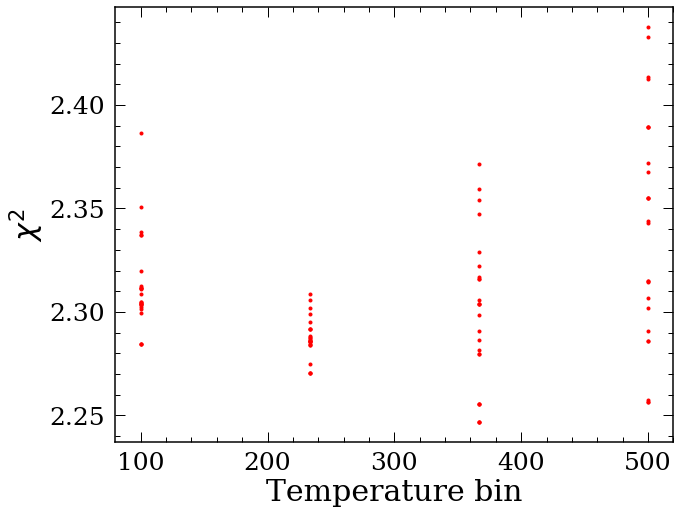

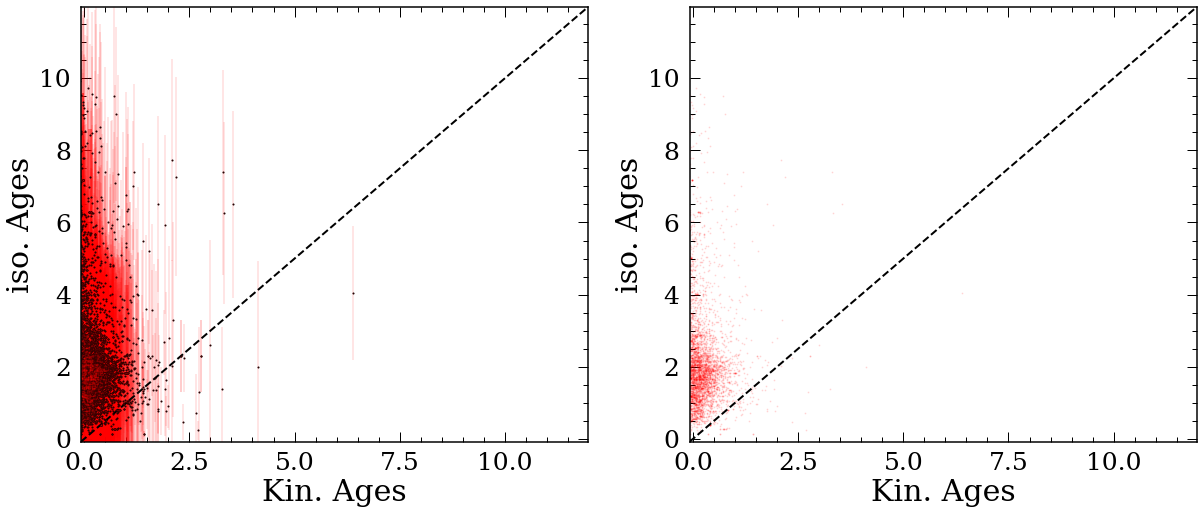

In [19]:
#### chisq
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,absg_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,absg_a)))

print('absg:',absg_a[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
print([tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])

getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],absg_a[0]])
#getkinAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[200.,0.4,0.5])

df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
"""
plt.errorbar(df_prot_s_plot['kin_age'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
"""
plt.errorbar(df_prot_s_plot['kin_age_Sharma2020'], df_prot_s_plot['iso_age'],
             yerr=df_prot_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_prot_s_plot['kin_age_Sharma2020'], df_prot_s_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_prot_s_plot['iso_age']),min(df_prot_s_plot['kin_age_Sharma2020']))
maxage=max(max(df_prot_s_plot['iso_age']),max(df_prot_s_plot['kin_age_Sharma2020']))

#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age'],1,w=1/np.power(df_prot_s['iso_age_err1'],2.))

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_prot_s_plot['kin_age_Sharma2020'], df_prot_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')


#df_prot_s.to_pickle('minchisq.pkl')



## average ages (real chisq)

In [ ]:
# get average ages in a bin
import scipy

tempbins=[400.,500.,600.,700.,800,900,1000]
protbins=[0.3,0.4,0.5,0.6,0.7]
loggbins=[0.1,0.2,0.5,0.7,0.8]
chisq=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            print(float(count)/float(total))
            count=count+1
            getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[i,j,k])
            df_prot_s=df_prot_s.dropna(subset=['kin_age','iso_age_ave','iso_age_ave_err'])
            stat_df=df_prot_s.loc[df_prot_s['iso_age']<10]
            chisq_single=sum(np.power(stat_df['kin_age']-stat_df['iso_age_ave'],2.)/stat_df['iso_age_ave_err'])
            chisq.append(chisq_single)
            tempbins_a.append(i)
            protbins_a.append(j)
            loggbins_a.append(k)
            #slope=df_prot_s
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[550.,0.03,0.2])
#getAveAges(df_prot_p,['teff_calc','Prot_log','logg_y'],[550.,0.07,0.2])

100%|██████████| 23158/23158 [00:07<00:00, 3266.50it/s]


Text(0, 0.5, 'iso. Ages')

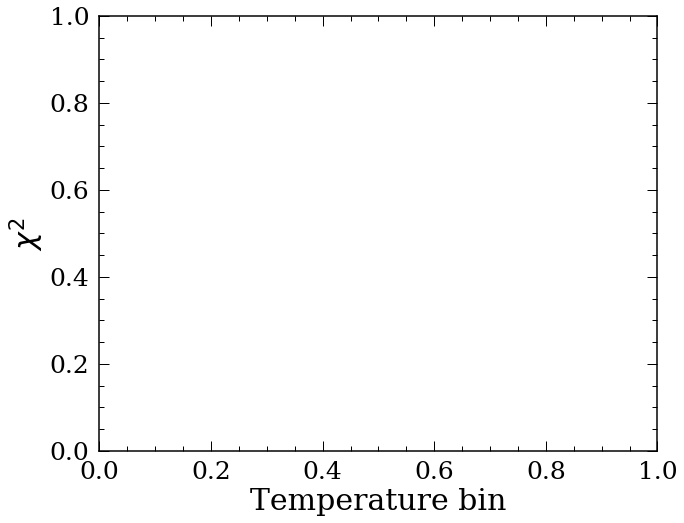

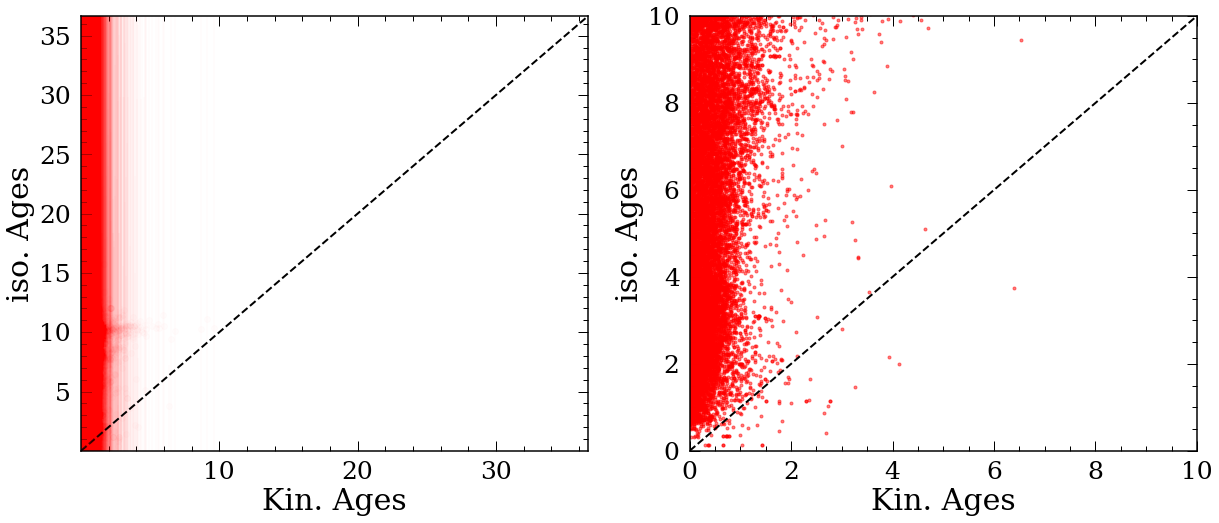

In [23]:
plt.figure(figsize=(10,8))
#plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

#chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a)))

#print(logg_a_s[0],rotbin_a_s[0],tempbin_a_s[0],chisq_s[0])

#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0]])
#getAveAges(df_prot_s,['teff_calc','Prot_log','logg_y'],[tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0]])
#getAveAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[100,0.4,0.5])
getAveAges(df_prot_s,['teff_calc','Prot_log','abs_G'],[366.6666666666667, 3.0, 0.01])


df_prot_s_plot=df_prot_s.loc[df_prot_s['iso_age']<10]
df_prot_s_plot=df_prot_s_plot.loc[df_prot_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_prot_s['kin_age_Sharma2020'], df_prot_s['iso_age_ave'],yerr=df_prot_s['iso_age_ave_err'],fmt='ro',alpha=0.01)
minage=min(min(df_prot_s['iso_age_ave']),min(df_prot_s['kin_age']))
maxage=max(max(df_prot_s['iso_age_ave']),max(df_prot_s['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
#plt.plot(df_prot_s['iso_age'],df_prot_s['kin_age'], 'r.',alpha=0.1)
plt.plot(df_prot_s['kin_age_Sharma2020'], df_prot_s['iso_age_ave'],'r.',alpha=0.5)
minage=min(min(df_prot_s['iso_age_ave']),min(df_prot_s['kin_age']))
maxage=max(max(df_prot_s['iso_age_ave']),max(df_prot_s['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
#plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
#plt.xlim([0.8*minage,1.2*maxage])
#plt.ylim([0.8*minage,1.2*maxage])
#plt.plot([0,10],np.polyval(z,[0,10]),'b--')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

#df_prot_s.to_pickle('minchisq.pkl')

# For Rvars

## real ages (real chisq)

In [22]:
np.linspace(0.3,10.,5)

array([ 0.3  ,  2.725,  5.15 ,  7.575, 10.   ])

In [23]:
# compare to real ages
import scipy

protbins=np.linspace(2,8,5)
loggbins=np.linspace(0.17,0.5,5)
tempbins=np.linspace(200.,400.,4)
absg=[0.01]

df_rvar_s['iso_age_err']=np.sqrt(df_rvar_s['iso_age_err1']**2.+df_rvar_s['iso_age_err2']**2.)

chisq=[]
tempbins_a=[]
protbins_a=[]
loggbins_a=[]
absg_a=[]
total=len(tempbins)*len(protbins)*len(loggbins)*len(absg)
count=1
for i in tempbins:
    for j in protbins:
        for k in loggbins:
            for l in absg:
                print(float(count)/float(total))
                count=count+1
                getkinAges(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],[i,j,k,l])
                stat_df=df_rvar_s.dropna(subset=['kin_age','iso_age','iso_age_err1'])
                if len(stat_df)<1000:
                    continue
                stat_df=stat_df.loc[stat_df['iso_age']<10]
                stat_df=stat_df.loc[stat_df['iso_age_err1']<3]
                chisq_sing=sum(np.power(stat_df['kin_age']-stat_df['iso_age'],2.)/stat_df['iso_age_err'])
                chisq.append(chisq_sing/len(stat_df))
                
                tempbins_a.append(i)
                protbins_a.append(j)
                loggbins_a.append(k)
                absg_a.append(l)


  0%|          | 44/84824 [00:00<03:17, 428.53it/s]

0.01


100%|██████████| 84824/84824 [01:52<00:00, 752.24it/s] 
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  0%|          | 79/84824 [00:00<01:48, 782.60it/s]

0.02


  0%|          | 212/84824 [00:00<01:20, 1053.88it/s]

0.03


  0%|          | 90/84824 [00:00<01:34, 896.07it/s]

0.04


  0%|          | 101/84824 [00:00<01:24, 1007.32it/s]

0.05


  0%|          | 97/84824 [00:00<01:27, 963.74it/s]

0.06


  0%|          | 102/84824 [00:00<01:23, 1011.53it/s]

0.07


  0%|          | 106/84824 [00:00<01:20, 1057.93it/s]

0.08


  0%|          | 97/84824 [00:00<01:27, 968.29it/s]

0.09


  0%|          | 103/84824 [00:00<01:22, 1024.74it/s]

0.1


  0%|          | 100/84824 [00:00<01:25, 990.15it/s]

0.11


  0%|          | 189/84824 [00:00<01:31, 922.60it/s]

0.12


  0%|          | 94/84824 [00:00<01:30, 932.09it/s]

0.13


  0%|          | 96/84824 [00:00<01:28, 954.26it/s]

0.14


  0%|          | 88/84824 [00:00<01:36, 876.49it/s]

0.15


  0%|          | 66/84824 [00:00<02:08, 657.25it/s]

0.16


  0%|          | 98/84824 [00:00<01:26, 976.95it/s]

0.17


  0%|          | 99/84824 [00:00<01:25, 988.79it/s]

0.18


  0%|          | 189/84824 [00:00<01:30, 939.88it/s]

0.19


  0%|          | 162/84824 [00:00<01:48, 782.10it/s]

0.2


  0%|          | 103/84824 [00:00<01:22, 1022.88it/s]

0.21


  0%|          | 96/84824 [00:00<01:29, 950.92it/s]

0.22


  0%|          | 102/84824 [00:00<01:23, 1015.09it/s]

0.23


  0%|          | 80/84824 [00:00<01:47, 789.92it/s]

0.24


  0%|          | 55/84824 [00:00<02:36, 541.97it/s]

0.25


  0%|          | 93/84824 [00:00<01:31, 925.91it/s]

0.26


  0%|          | 94/84824 [00:00<01:30, 932.66it/s]

0.27


  0%|          | 198/84824 [00:00<01:25, 987.83it/s]

0.28


  0%|          | 98/84824 [00:00<01:26, 978.58it/s]

0.29


  0%|          | 65/84824 [00:00<02:10, 649.96it/s]

0.3


  0%|          | 195/84824 [00:00<01:27, 968.56it/s]

0.31


  0%|          | 68/84824 [00:00<02:05, 677.75it/s]

0.32


  0%|          | 187/84824 [00:00<01:30, 930.29it/s]

0.33


  0%|          | 82/84824 [00:00<01:44, 813.93it/s]

0.34


  0%|          | 198/84824 [00:00<01:26, 983.16it/s]

0.35


  0%|          | 179/84824 [00:00<01:34, 892.11it/s]

0.36


  0%|          | 62/84824 [00:00<02:21, 600.91it/s]

0.37


  0%|          | 94/84824 [00:00<01:30, 931.81it/s]

0.38


  0%|          | 102/84824 [00:00<01:23, 1011.61it/s]

0.39


  0%|          | 103/84824 [00:00<01:22, 1027.52it/s]

0.4


  0%|          | 95/84824 [00:00<01:29, 944.29it/s]

0.41


  0%|          | 100/84824 [00:00<01:25, 992.63it/s]

0.42


  0%|          | 106/84824 [00:00<01:20, 1057.45it/s]

0.43


  0%|          | 101/84824 [00:00<01:24, 1007.81it/s]

0.44


  0%|          | 105/84824 [00:00<01:21, 1042.32it/s]

0.45


  0%|          | 210/84824 [00:00<01:21, 1039.56it/s]

0.46


  0%|          | 105/84824 [00:00<01:21, 1045.17it/s]

0.47


  0%|          | 76/84824 [00:00<01:51, 759.74it/s]

0.48


  0%|          | 107/84824 [00:00<01:19, 1060.52it/s]

0.49


  0%|          | 204/84824 [00:00<01:23, 1009.56it/s]

0.5


  0%|          | 88/84824 [00:00<01:36, 875.64it/s]

0.51


  0%|          | 103/84824 [00:00<01:22, 1023.95it/s]

0.52


  0%|          | 99/84824 [00:00<01:25, 985.59it/s]

0.53


  0%|          | 105/84824 [00:00<01:20, 1048.94it/s]

0.54


  0%|          | 212/84824 [00:00<01:20, 1056.87it/s]

0.55


  0%|          | 203/84824 [00:00<01:23, 1007.84it/s]

0.56


  0%|          | 78/84824 [00:00<01:49, 773.89it/s]

0.57


  0%|          | 43/84824 [00:00<03:21, 420.38it/s]

0.58


  0%|          | 101/84824 [00:00<01:24, 1001.08it/s]

0.59


  0%|          | 200/84824 [00:00<01:24, 999.78it/s] 

0.6


  0%|          | 95/84824 [00:00<01:29, 944.79it/s]

0.61


  0%|          | 65/84824 [00:00<02:11, 646.01it/s]

0.62


  0%|          | 81/84824 [00:00<01:45, 806.41it/s]

0.63


  0%|          | 73/84824 [00:00<01:56, 725.43it/s]

0.64


  0%|          | 74/84824 [00:00<01:54, 739.59it/s]

0.65


  0%|          | 113/84824 [00:00<01:15, 1122.22it/s]

0.66


  0%|          | 98/84824 [00:00<01:26, 978.83it/s]

0.67


  0%|          | 104/84824 [00:00<01:21, 1038.86it/s]

0.68


  0%|          | 99/84824 [00:00<01:25, 987.61it/s]

0.69


  0%|          | 116/84824 [00:00<01:13, 1158.47it/s]

0.7


  0%|          | 118/84824 [00:00<01:12, 1169.88it/s]

0.71


  0%|          | 106/84824 [00:00<01:20, 1048.68it/s]

0.72


  0%|          | 114/84824 [00:00<01:14, 1139.23it/s]

0.73


  0%|          | 104/84824 [00:00<01:21, 1038.55it/s]

0.74


  0%|          | 106/84824 [00:00<01:20, 1056.66it/s]

0.75


  0%|          | 238/84824 [00:00<01:11, 1189.07it/s]

0.76


  0%|          | 209/84824 [00:00<01:21, 1037.09it/s]

0.77


  0%|          | 42/84824 [00:00<03:24, 415.07it/s]

0.78


  0%|          | 229/84824 [00:00<01:14, 1135.94it/s]

0.79


  0%|          | 115/84824 [00:00<01:13, 1146.22it/s]

0.8


  0%|          | 118/84824 [00:00<01:12, 1172.14it/s]

0.81


  0%|          | 117/84824 [00:00<01:12, 1161.62it/s]

0.82


  0%|          | 111/84824 [00:00<01:16, 1106.04it/s]

0.83


  0%|          | 225/84824 [00:00<01:15, 1116.50it/s]

0.84


  0%|          | 207/84824 [00:00<01:21, 1036.90it/s]

0.85


  0%|          | 113/84824 [00:00<01:15, 1119.25it/s]

0.86


  0%|          | 112/84824 [00:00<01:15, 1115.10it/s]

0.87


  0%|          | 80/84824 [00:00<01:46, 796.92it/s]

0.88


  0%|          | 110/84824 [00:00<01:17, 1091.11it/s]

0.89


  0%|          | 113/84824 [00:00<01:15, 1121.41it/s]

0.9


  0%|          | 115/84824 [00:00<01:14, 1139.44it/s]

0.91


  0%|          | 112/84824 [00:00<01:15, 1118.58it/s]

0.92


  0%|          | 100/84824 [00:00<01:25, 992.61it/s]

0.93


  0%|          | 113/84824 [00:00<01:15, 1127.62it/s]

0.94


  0%|          | 228/84824 [00:00<01:14, 1137.16it/s]

0.95


  0%|          | 114/84824 [00:00<01:14, 1134.51it/s]

0.96


  0%|          | 104/84824 [00:00<01:21, 1033.93it/s]

0.97


  0%|          | 85/84824 [00:00<01:40, 846.71it/s]

0.98


  0%|          | 118/84824 [00:00<01:11, 1178.21it/s]

0.99


  0%|          | 108/84824 [00:00<01:19, 1071.82it/s]

1.0


100%|██████████| 84824/84824 [01:24<00:00, 998.27it/s] 


100%|██████████| 84824/84824 [00:54<00:00, 1552.66it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Text(0, 0.5, 'iso. Ages')

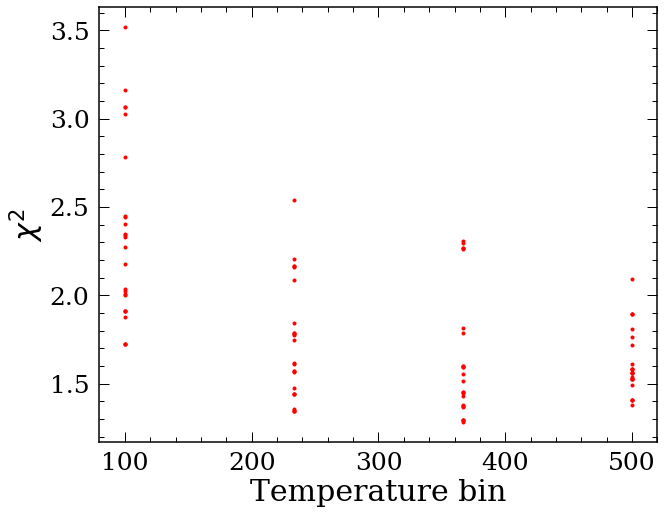

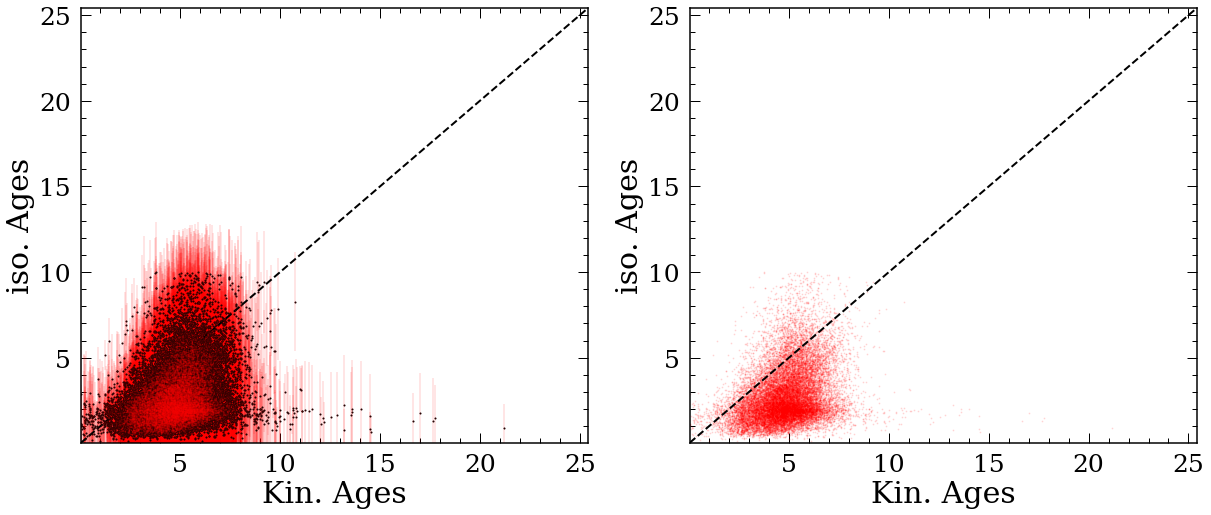

In [68]:
plt.figure(figsize=(10,8))
plt.plot(tempbins_a,chisq,'r.')
plt.xlabel('Temperature bin')
plt.ylabel('$\chi^2$')

chisq_s,rotbin_a_s,tempbin_a_s,logg_a_s=zip(*sorted(zip(chisq,protbins_a,tempbins_a,loggbins_a)))

#print('absg:',absg_a[0],'logg:',logg_a_s[0],'prot:',rotbin_a_s[0],'temp:',tempbin_a_s[0],chisq_s[0])
#print([tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]])

getkinAges(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],
           [266.6666666666667, 5.0, 0.4175, 0.01])

df_rvar_s_plot=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s_plot=df_rvar_s_plot.loc[df_rvar_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],
             yerr=df_rvar_s_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],
         'ko',alpha=1,markersize=1)
minage=min(min(df_rvar_s_plot['iso_age']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age']),max(df_rvar_s_plot['kin_age']))

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age'],'ro',alpha=0.1,markersize=1)

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

df_rvar_s.to_pickle('minchisq_rvar.pkl')



In [28]:
df_rvar_s.loc[df_rvar_s['KID']==11075611]

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age
73535,11075611,0.539,0.013,-0.013,3761.3,77.3,-77.3,4.686,0.013,-0.013,...,11075611,4.530539,4689.908028,3504.631839,3.671164,4.917,-9.770699,8.817705,9.117511,4.346705


In [29]:
df_rvar_s.loc[df_rvar_s['KID']==12456401]

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age
84040,12456401,0.526,0.012,-0.013,3809.6,81.2,-71.5,4.704,0.012,-0.012,...,12456401,4.385001,4237.663746,3679.311078,3.627126,4.826,7.88599,8.63656,9.347304,2.313152


In [77]:
getAveAges(df_rvar_s,['teff_calc','Rvar_log','abs_G'],
           [266.6666666666667, 5.0, 0.01])



100%|██████████| 84824/84824 [01:11<00:00, 1194.37it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


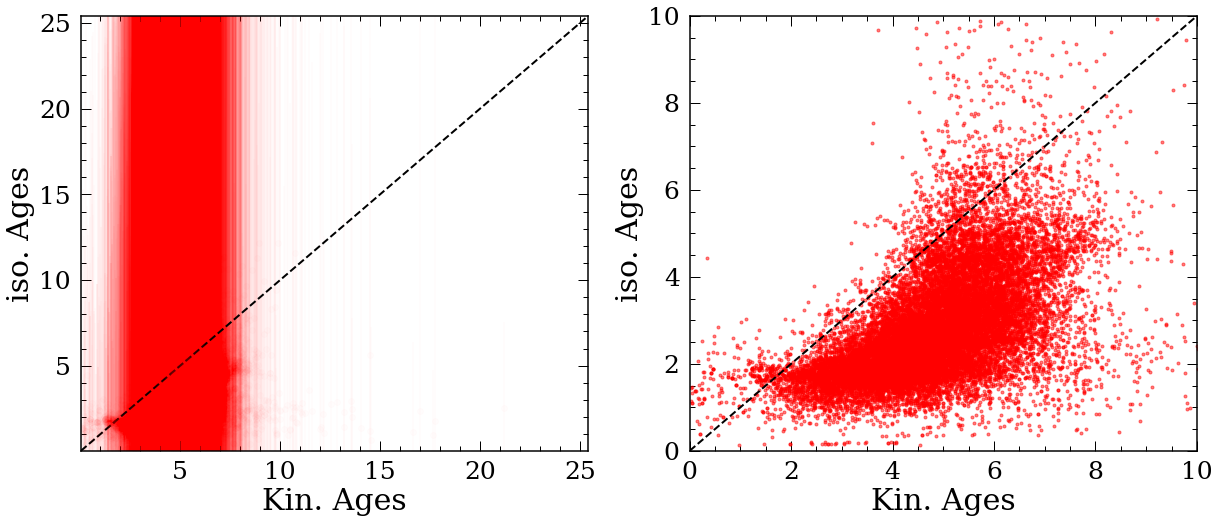

In [79]:
df_rvar_s_plot=df_rvar_s.loc[df_rvar_s['iso_age']<10]
df_rvar_s_plot=df_rvar_s_plot.loc[df_rvar_s_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age_ave'],yerr=df_rvar_s_plot['iso_age_ave_err'],fmt='ro',alpha=0.01)
minage=min(min(df_rvar_s_plot['iso_age_ave']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age_ave']),max(df_rvar_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
#plt.plot(df_prot_s['iso_age'],df_prot_s['kin_age'], 'r.',alpha=0.1)
plt.plot(df_rvar_s_plot['kin_age'], df_rvar_s_plot['iso_age_ave'],'r.',alpha=0.5)
minage=min(min(df_rvar_s_plot['iso_age_ave']),min(df_rvar_s_plot['kin_age']))
maxage=max(max(df_rvar_s_plot['iso_age_ave']),max(df_rvar_s_plot['kin_age']))
#z=np.polyfit(df_prot_s['kin_age'],df_prot_s['iso_age_ave'],1)
#plt.plot([0.8*minage,1.2*maxage],np.polyval(z,[0.8*minage,maxage]),'b--')
#plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
#plt.xlim([0.8*minage,1.2*maxage])
#plt.ylim([0.8*minage,1.2*maxage])
#plt.plot([0,10],np.polyval(z,[0,10]),'b--')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

plt.savefig('wologg.png')
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [39]:

    

ages=getkinAges_err(df_rvar_s,['teff_calc','Rvar_log','logg','abs_G'],
           [tempbin_a_s[0],rotbin_a_s[0],logg_a_s[0],absg_a[0]],sampsize=50) 



100%|██████████| 84824/84824 [01:20<00:00, 1051.85it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 84824/84824 [01:25<00:00, 986.87it/s] 


(array([25., 14.,  5.,  1.,  0.,  0.,  1.,  1.,  2.,  1.]),
 array([5.54410196, 5.73763689, 5.93117181, 6.12470674, 6.31824166,
        6.51177659, 6.70531151, 6.89884643, 7.09238136, 7.28591628,
        7.47945121]),
 <a list of 10 Patch objects>)

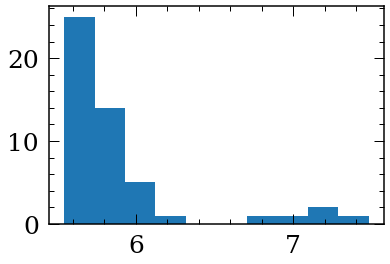

In [81]:
plt.hist(ages[10,:])

In [3]:
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,Rvar_log,logg,v_b,abs_G,iso_age_err,kin_age,iso_age_ave,iso_age_ave_err,kin_age_err,source_id
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,4.335097,4.500,-33.411547,5.517761,7.433176,6.050929,6.389688,759.97,0.671505,2.050232e+18
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,3.505987,4.574,-4.214296,6.159685,8.361459,5.329557,6.602250,496.15,0.834650,2.050232e+18
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,3.252893,4.547,36.144482,5.998116,7.047929,5.374382,9.921913,443.54,1.041803,2.050236e+18
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,3.464520,4.560,26.448217,6.161795,8.510323,4.650196,6.560067,469.66,1.334890,2.050233e+18
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,4.180735,4.615,-0.966857,6.411296,8.748257,2.800943,7.478731,388.49,0.448719,2.050232e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84819,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,3.449165,4.500,18.829108,6.176964,6.371766,3.519965,15.195308,59.82,1.223089,2.139326e+18
84820,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,3.255194,4.571,-10.180756,4.676241,4.325101,3.603349,16.875361,64.17,0.613842,2.139336e+18
84821,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,3.309001,4.423,4.480242,4.376738,3.396115,6.606545,4.493451,475.13,0.684779,2.139336e+18
84822,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,4.028109,4.579,-0.407244,5.892401,8.148325,6.852331,9.580305,574.14,0.544911,2.139342e+18


In [46]:
df_rvar_s=pd.read_pickle('minchisq_rvar.pkl')

In [56]:
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [50]:
age_err=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df_rvar_s))] 

In [51]:
df_rvar_s['kin_age_err']=age_err

In [55]:
df_rvar_s=pd.merge(df_rvar_s,pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')[['KID','source_id']],left_on='KID',right_on='KID',how='inner')

In [54]:
df_rvar_p

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,iso_gof,TAMS\\,KID,age,Rvar,teff_calc,Rvar_log,logg,v_b,abs_G
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,1.0,16.1\\,757450,3.169943,21632.027626,5313.795979,4.335097,4.500,-33.411547,5.517761
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,1.0,23.06\\,892718,4.666500,3206.175566,5058.354128,3.505987,4.574,-4.214296,6.159685
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,1.0,24.12\\,892772,4.925885,1790.165901,4898.417653,3.252893,4.547,36.144482,5.998116
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,1.0,23.42\\,892832,4.717011,2914.205194,5059.657160,3.464520,4.560,26.448217,6.161795
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,1.0,27.05\\,892834,3.633430,15161.266923,4856.095860,4.180735,4.615,-0.966857,6.411296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84820,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,1.0,27.52\\,12935144,4.581993,2812.966704,4623.859643,3.449165,4.500,18.829108,6.176964
84821,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,1.0,15.52\\,12983952,4.896960,1799.672842,5347.731327,3.255194,4.571,-10.180756,4.676241
84822,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,1.0,7.49\\,12984012,4.455203,2037.048340,6043.922841,3.309001,4.423,4.480242,4.376738
84823,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,1.0,22.31\\,12984138,4.025700,10668.635368,5044.668752,4.028109,4.579,-0.407244,5.892401


In [83]:
list(pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl').columns)

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g

In [45]:
df=pd.read_pickle('NewData/RvarVP_MS_150_w015_bin.pkl')

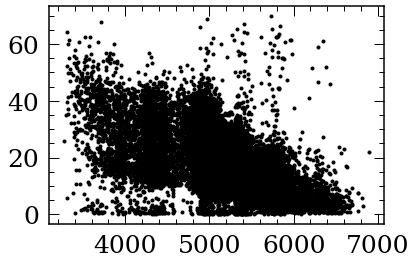

In [92]:
plt.plot(df['teff_val'],df['Prot'],'k.')

In [3]:
def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX



In [ ]:
testing=10000
px_s=getErr(df['parallax'].values,df['parallax_error'].values,testing)
pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,testing)
pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,testing)
ra_s=getErr(df['ra'].values,df['ra_error'].values,testing)
dec_s=getErr(df['dec'].values,df['dec_error'].values,testing)


In [12]:
np.shape(px_s)

(88561, 10000)

In [10]:
testing=10000
vts=np.zeros((len(df),testing))
vbs=np.zeros((len(df),testing))
for i in trange(testing):
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,1)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,1)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,1)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,1)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,1)
    vts[:,i],vbs[:,i]=getVs(px_s[:,0],pmra_s[:,0],pmdec_s[:,0],ra_s[:,0],dec_s[:,0])
    
    

100%|██████████| 10000/10000 [5:13:36<00:00,  1.88s/it] 


In [17]:
vt_err=np.zeros(len(df))
vb_err=np.zeros(len(df))

for i in trange(len(df)):
    vt_err[i]=np.std(vts[i,:])
    vb_err[i]=np.std(vbs[i,:])

100%|██████████| 88561/88561 [02:02<00:00, 725.52it/s] 


array([0.77786295, 0.77786295, 0.77786295, ..., 0.77786295, 0.77786295,
       0.77786295])

In [18]:
df['v_t_err']=vt_err
df['v_b_err']=vb_err


In [4]:
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

In [5]:
testing=10000
absg_err=np.zeros((len(df),testing))

for i in trange(testing):
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,1)
    absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,0])


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
100%|██████████| 10000/10000 [1:01:29<00:00,  2.71it/s]


In [6]:
absg_err_err=np.zeros(len(df))
for i in trange(len(df)):
    absg_err_err[i]=np.std(absg_err[i,:])

100%|██████████| 88561/88561 [00:39<00:00, 2224.82it/s]


In [7]:
df['abs_G_err']=absg_err_err

In [47]:
#add_col=['v_t_err','v_b_err','abs_G_err']
add_col=['designation']
columns_non=[i for i in df_rvar_s.columns if i not in add_col]
len(columns_non)

57

In [48]:
df_rvar_s=pd.merge(df_rvar_s[columns_non],df[np.append(['KID'],add_col)],left_on='KID',right_on='KID',how='inner')

In [49]:
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,abs_G_err,teff_val_err,Rvar_err,Rvar_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis,designation
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,0.048368,95.500000,0.0,21632.027626,5313.256900,5.455146,-35.277039,1.118617,18.600038,Gaia DR2 2050231848829944320
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,0.072800,41.750000,0.0,3206.175566,5064.927763,6.292640,-3.936550,1.618687,17.131106,Gaia DR2 2050232364226074624
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,0.108144,130.961426,0.0,1790.165901,4991.228808,5.994973,34.959310,2.666831,17.199199,Gaia DR2 2050235731480463616
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,0.056932,89.566162,0.0,2914.205194,5067.718138,6.121626,26.577679,1.696985,16.163337,Gaia DR2 2050232776542967680
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.030969,228.925049,0.0,15161.266923,4744.037378,6.376287,-0.851973,1.701146,11.371647,Gaia DR2 2050232089348169856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84028,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,0.038313,90.559814,0.0,2812.966704,4873.988467,6.144015,18.589346,2.031084,13.146935,Gaia DR2 2139325653978247808
84029,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,0.058895,91.278564,0.0,1799.672842,5337.222521,4.794033,-9.283707,2.122039,13.343811,Gaia DR2 2139336408576560512
84030,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,0.075262,287.665039,0.0,2037.048340,6339.111888,4.363923,4.436810,1.459457,19.784621,Gaia DR2 2139336099338925312
84031,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,0.065799,75.750000,0.0,10668.635368,5184.729625,5.970433,-0.967112,1.025516,20.067518,Gaia DR2 2139341768695774336


In [52]:
df_rvar_s.to_pickle('minchisq_rvar.pkl')

In [15]:
df['teff_calc']

0        5313.795979
1        3783.045568
2        5058.354128
3        4898.417653
4        5059.657160
            ...     
88556    5347.731327
88557    6043.922841
88558    5044.668752
88559    5305.874615
88560    5180.812805
Name: teff_calc, Length: 88561, dtype: float64

In [16]:
df['teff_val_err']=(df['teff_percentile_upper']-df['teff_percentile_lower'])/2.
df['teff_val_err']


0         95.500000
1        440.333252
2         41.750000
3        130.961426
4         89.566162
            ...    
88556     91.278564
88557    287.665039
88558     75.750000
88559    505.108887
88560     60.407471
Name: teff_val_err, Length: 88561, dtype: float64

In [17]:
df_rvar_s=pd.merge(df_rvar_s,df[np.append(['KID'],['teff_val_err'])],left_on='KID',right_on='KID',how='inner')



In [50]:
pd.read_pickle('minchisq_rvar.pkl')

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,v_b_err,abs_G_err,teff_val_err,Rvar_err,Rvar_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,0.768051,0.048368,95.500000,0.0,21632.027626,5313.256900,5.455146,-35.277039,1.118617,18.600038
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,0.333401,0.072800,41.750000,0.0,3206.175566,5064.927763,6.292640,-3.936550,1.618687,17.131106
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,1.886702,0.108144,130.961426,0.0,1790.165901,4991.228808,5.994973,34.959310,2.666831,17.199199
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,0.730871,0.056932,89.566162,0.0,2914.205194,5067.718138,6.121626,26.577679,1.696985,16.163337
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.129022,0.030969,228.925049,0.0,15161.266923,4744.037378,6.376287,-0.851973,1.701146,11.371647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84028,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,0.368733,0.038313,90.559814,0.0,2812.966704,4873.988467,6.144015,18.589346,2.031084,13.146935
84029,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,0.394648,0.058895,91.278564,0.0,1799.672842,5337.222521,4.794033,-9.283707,2.122039,13.343811
84030,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,0.386915,0.075262,287.665039,0.0,2037.048340,6339.111888,4.363923,4.436810,1.459457,19.784621
84031,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,0.314944,0.065799,75.750000,0.0,10668.635368,5184.729625,5.970433,-0.967112,1.025516,20.067518


In [51]:
df_rvar_s

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,abs_G_err,teff_val_err,Rvar_err,Rvar_new,teff_calc_new,abs_G_new,v_b_new,kin_age_err_bs,vel_dis,designation
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,0.048368,95.500000,0.0,21632.027626,5313.256900,5.455146,-35.277039,1.118617,18.600038,Gaia DR2 2050231848829944320
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,0.072800,41.750000,0.0,3206.175566,5064.927763,6.292640,-3.936550,1.618687,17.131106,Gaia DR2 2050232364226074624
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,0.108144,130.961426,0.0,1790.165901,4991.228808,5.994973,34.959310,2.666831,17.199199,Gaia DR2 2050235731480463616
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,0.056932,89.566162,0.0,2914.205194,5067.718138,6.121626,26.577679,1.696985,16.163337,Gaia DR2 2050232776542967680
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,0.030969,228.925049,0.0,15161.266923,4744.037378,6.376287,-0.851973,1.701146,11.371647,Gaia DR2 2050232089348169856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84028,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,0.038313,90.559814,0.0,2812.966704,4873.988467,6.144015,18.589346,2.031084,13.146935,Gaia DR2 2139325653978247808
84029,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,0.058895,91.278564,0.0,1799.672842,5337.222521,4.794033,-9.283707,2.122039,13.343811,Gaia DR2 2139336408576560512
84030,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,0.075262,287.665039,0.0,2037.048340,6339.111888,4.363923,4.436810,1.459457,19.784621,Gaia DR2 2139336099338925312
84031,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,0.065799,75.750000,0.0,10668.635368,5184.729625,5.970433,-0.967112,1.025516,20.067518,Gaia DR2 2139341768695774336
